# ReplayBuffer du cours DQN

In [127]:
import random
import torch

class Buffer:
    def __init__(self, capacity):
        self.capacity = capacity # capacity of the buffer
        self.data = []
        self.index = 0 # index of the next cell to be filled

    def append(self, s, a, r, s_, d):
        if len(self.data) < self.capacity:
            self.data.append(None)
        self.data[self.index] = (s, a, r, s_, d)
        self.index = (self.index + 1) % self.capacity
    
    def get(self):
        state = np.stack([self.data[i][0] for i in range(len(self.data))])
        action = np.stack([self.data[i][1] for i in range(len(self.data))])
        action = np.expand_dims(action, axis=1)
        reward = np.array([self.data[i][2] for i in range(len(self.data))])
        next_state = np.stack([self.data[i][3] for i in range(len(self.data))])
        done = np.array([self.data[i][4] for i in range(len(self.data))])
        
        return state, action, reward, next_state, done

    def len(self):
        return len(self.data)

# Requeter le simulateur (hiv_patient)

In [128]:
# IMPORTS
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from hiv_patient import HIVPatient
from tqdm import trange

In [144]:
# Simulate unhealthy patient
patient = HIVPatient(clipping=False,logscale=False)
buff = Buffer(12000)
step = 1 # Pour les tests petit step

# Actions : OneHotEncoder
#action = { 0 : np.array([0, 0, 0, 1]), 1 : np.array([0, 0, 1, 0]), 2 : np.array([0, 1, 0, 0]), 3 : np.array([1, 0, 0, 0])}
action = np.array([0, 1, 2, 3])

# Fill buffer with initial sample randomly generated
for j in range(step):
    s = patient.reset(mode="unhealthy")
    dur = 4000 # 200 jours / 5 jours
    for i in trange(dur):
        a = np.random.randint(3)
        s_, r, d, _ = patient.step(a)
        s = s_
        buff.append(s,a,r,s_,d)
        


100%|███████████████████████████████████████| 4000/4000 [04:34<00:00, 14.55it/s]


In [145]:
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestRegressor
from typing import Optional, List

def update(memory : Buffer, action_list : List[np.ndarray], gamma : float = 0.98, estimator_factory  : RandomForestRegressor = RandomForestRegressor, estimator : Optional[BaseEstimator] = None):
    state, action, reward, _, _ = memory.get()
    x_list = np.concatenate((state,action),axis=1)
    target = reward
    qmax = []
        
    if estimator is not None:
        q_values = []
        
        for a in action_list:
            a_ = a*np.ones((len(state),1))
            X = np.concatenate((state,a_),axis=1)
            e = estimator.predict(X)
            q_values = np.append(q_values,e)
            
        qmax = np.max(q_values)
        
        target += gamma*qmax
    
    if estimator is None:
        estimator = estimator_factory()
        
    estimator.fit(x_list, target)
    
    return estimator

In [146]:
# Fill buffer with next sample : 85% strategy from last sample, 15% random
for j in range(1):
    print('Buffer length at step ',j)
    print(buff.len())
    s = patient.reset(mode="unhealthy")
    dur = 4000 # 2000 jours / 5 jours
    e = None
    e = update(buff, action, estimator = e)
    
    for i in trange(dur):
        k = np.random.rand()
        a = 0
        
        if k < 0.15:   
            a = np.random.randint(3)
            
        else:
            q_list = []
            a_list = []
            
            for aa in action:
                sa = np.append(s,[aa])
                sa = np.expand_dims(sa, axis=1).transpose()
                p = e.predict(sa)
                q_list.append(p)
                a_list.append(aa)
                
            i = q_list.index(max(q_list))
            a = a_list[i]
            
        s_, r, d, _ = patient.step(a)
        s = s_
        
        if i%400:
            
            e = update(buff, action, estimator = e)
            
            
        buff.append(s,a,r,s_,d)

Buffer length at step  0
4000


100%|███████████████████████████████████████| 4000/4000 [59:16<00:00,  1.12it/s]


In [147]:
# Print trajectories
def plot_traj(buff):
    s,_,_,_,_ = buff.get()
    print(s.shape)
    T1 = s[:,0]
    T1_ = s[:,1]
    T2 = s[:,2]
    T2_ = s[:,3]
    V = s[:,4]
    E = s[:,5]
    
    fig, axs = plt.subplots(2, 3, figsize=(15, 15))
    axs[0,0].plot(T1)
    axs[0,0].set_title("T1")
    axs[0,1].plot(T1_)
    axs[0,1].set_title("T1*")
    axs[0,2].plot(T2)
    axs[0,2].set_title("T2")
    axs[1,0].plot(T2_)
    axs[1,0].set_title("T2*")
    axs[1,1].plot(V)
    axs[1,1].set_title("V")
    axs[1,2].plot(E)
    axs[1,2].set_title("E")
    


(8000, 6)


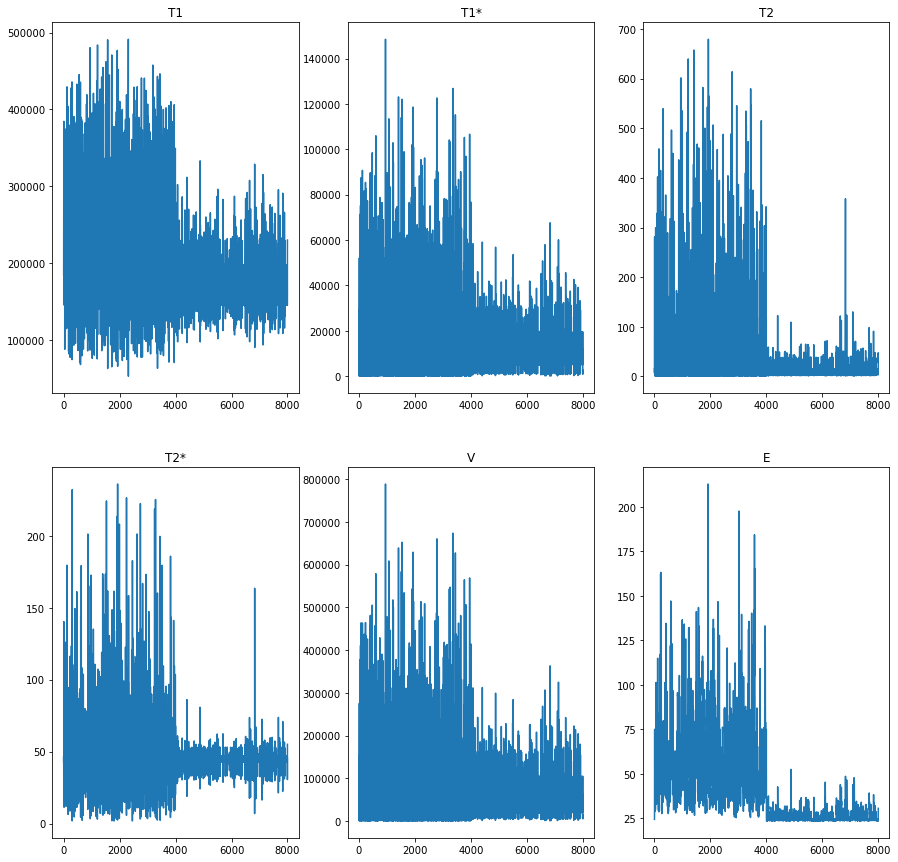

In [148]:
plot_traj(buff)